In [ ]:
import pandas as pd
import numpy as np

# load df_wikitext_sentences from csv
df_wikitext_sentences = pd.read_csv("../data/wikitext_sentences.csv")
# load df_controlled from csv
df_controlled = pd.read_csv("../data/controlled_sentences.csv")

In [ ]:
df_wikitext_sentences.sample(10)

In [ ]:
df_controlled.groupby(['Category', 'Inflection Label']).sample(n=2).reset_index(drop=True)

In [ ]:
# how many unique lemmas in df_wikitext_sentences
unique_lemmas_wikitext = df_wikitext_sentences['Lemma'].nunique()
# how many unique lemmas in df_controlled
unique_lemmas_controlled = df_controlled['Lemma'].nunique()
print(f"Unique lemmas in wikitext sentences: {unique_lemmas_wikitext}")
print(f"Unique lemmas in controlled sentences: {unique_lemmas_controlled}")

# how many sentences in df_wikitext_sentences
num_sentences_wikitext = df_wikitext_sentences.shape[0]
# how many sentences in df_controlled
num_sentences_controlled = df_controlled.shape[0]
print(f"Number of sentences in wikitext sentences: {num_sentences_wikitext}")
print(f"Number of sentences in controlled sentences: {num_sentences_controlled}")

In [ ]:
# Update the CSV file path as necessary
csv_file = "../data/wikitext_sentences.csv"  # Change this to the path of your dataset CSV file

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file)
print(f"Dataset loaded with {len(df)} examples.\n")

# --- 1. Dataset Balance Diagnostics ---

# Check distribution of Lemma labels
print("Lemma Distribution (count per class):")
lemma_counts = df["Lemma"].value_counts()
print(lemma_counts, "\n")

# Plot the lemma distribution as a bar chart (if there are many classes, you might want to limit the number displayed)
plt.figure(figsize=(12, 6))
lemma_counts.plot(kind="bar")
plt.title("Lemma Distribution")
plt.xlabel("Lemma")
plt.ylabel("Count")
plt.xticks([])  # Remove x-axis labels
plt.tight_layout()
plt.show()

# Check distribution of inflection labels (e.g., "present" vs. "past")
print("Inflection Label Distribution (count per class):")
inflection_counts = df["Inflection Label"].value_counts()
print(inflection_counts, "\n")

# Plot the inflection label distribution
plt.figure(figsize=(6, 4))
inflection_counts.plot(kind="bar", color='skyblue')
plt.title("Inflection Label Distribution")
plt.xlabel("Inflection Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 2. Tokenization Diagnostics for Lemma ---

# Load GPT-2 tokenizer (or change to the appropriate model)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Define a helper function to tokenize a given word
def tokenize_word(word):
    tokens = tokenizer.tokenize(word)
    return tokens

# Apply tokenization to the Lemma column (ensure it is string type)
df["Tokenized Lemma"] = df["Lemma"].astype(str).apply(tokenize_word)

# Display a few examples of tokenized Lemmas
print("Examples of Lemma Tokenization:")
print(df[["Lemma", "Tokenized Lemma"]].head(10), "\n")

# Diagnose how many Lemma instances are tokenized into multiple tokens
df["Num_Tokens"] = df["Tokenized Lemma"].apply(len)
multi_token_count = (df["Num_Tokens"] > 1).sum()
print(f"Number of lemma instances tokenized into multiple tokens: {multi_token_count}")
print(f"Percentage of multi-token lemmas: {100 * multi_token_count/len(df):.2f}%\n")

# Additionally, check the uniqueness across Lemma types:
unique_lemmas = df["Lemma"].dropna().unique()
multi_token_unique = sum(1 for lex in unique_lemmas if len(tokenize_word(str(lex))) > 1)
print(f"Unique lemmas tokenized into multiple tokens: {multi_token_unique} out of {len(unique_lemmas)}")

# --- 3. Additional Diagnostics ---

# You can include other diagnostics as needed, for instance:
# - Checking for missing or NaN values in key columns
for column in ["Lemma", "Inflection Label", "Sentence", "Target Index"]:
    missing = df[column].isna().sum()
    print(f"Missing values in '{column}': {missing}")

# - Basic statistics: total number of examples, unique lemmas, etc.
print(f"\nTotal number of examples: {len(df)}")
print(f"Number of unique lemmas: {len(unique_lemmas)}")
print(f"Number of unique inflection labels: {df['Inflection Label'].nunique()}")


In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

dataset = "ud_gum_dataset"
model_name = "gpt2"
probe_dirs = [
    f"../output/probes/{dataset}_{model_name}_lexeme",
    f"../output/probes/{dataset}_{model_name}_inflection", 
]

def extract_probe_type(probe_dir):
    """Extracts the probe type from the directory name."""
    match = re.search(r""+dataset+r"_(.*?)$", probe_dir)
    if match:
        return match.group(1)
    return "Unknown"

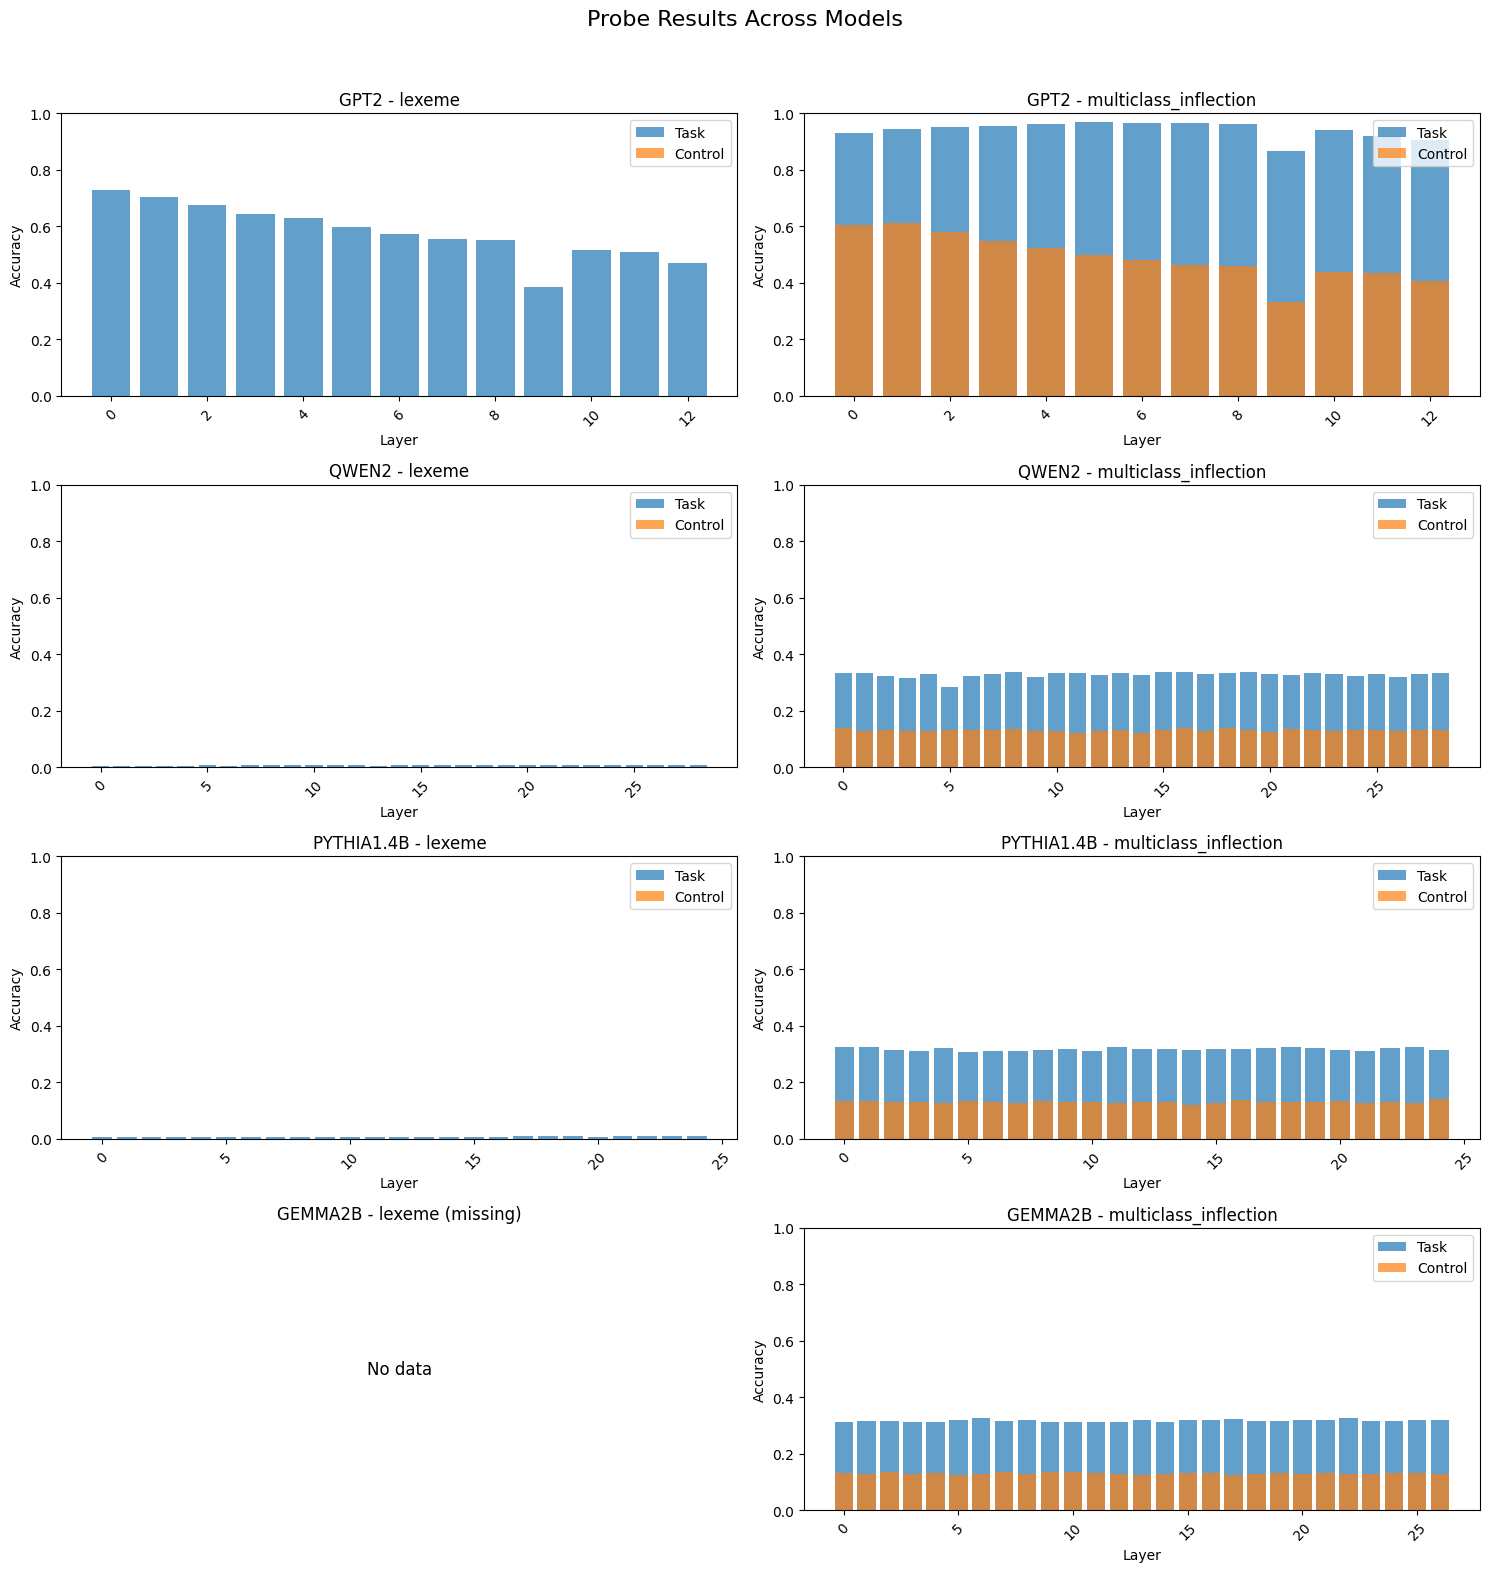

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd

models = ["gpt2", "qwen2", "pythia1.4b", "gemma2b"]
dataset = "ud_gum_dataset"

# Create a figure with 4x2 subplots (4 models, 2 probe types)
fig, axes = plt.subplots(len(models), 2, figsize=(15, 4 * len(models)))
plt.subplots_adjust(top=0.90, hspace=0.4)

fig.suptitle('Probe Results Across Models', fontsize=16)

for idx, model in enumerate(models):
    probe_dirs = [
        f"../output/probes/{dataset}_{model}_lexeme",
        f"../output/probes/{dataset}_{model}_inflection",
    ]
    for col, probe_dir in enumerate(probe_dirs):
        ax = axes[idx, col]
        # infer probe type from directory name
        probe_type = probe_dir.split(f"{model}_")[-1]
        csv_path = os.path.join(probe_dir, f"{probe_type}_results.csv")
        
        # handle missing data (e.g. gemma2b lexeme probe)
        if not os.path.exists(csv_path):
            ax.axis('off')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_title(f"{model.upper()} - {probe_type} (missing)")
            continue
        
        df = pd.read_csv(csv_path)
        # choose columns
        if "inflection" in probe_type:
            task_col, control_col = "Inflection_Task", "Inflection_Control"
        else:
            task_col, control_col = "Lexeme_Task", "Lexeme_Control"
        
        # plot
        ax.bar(df['Layer'], df[task_col], label='Task', alpha=0.7)
        ax.bar(df['Layer'], df[control_col], label='Control', alpha=0.7)
        ax.set_xlabel("Layer")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{model.upper()} - {probe_type}")
        ax.set_ylim(0, 1)
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()